## Locating the PC Boundaries for Anomalies

* Isolation Forest: Use an ensemble of shallow binary trees that split the data into two groups.
    * At each iteration, a boundary line is drawn across the dataset, and each point is given a score
        * The score is the fraction of all points on either side of the boundary line
        * The overall outlier score is the average score across each iteration
        * Points that are located further away from the main cluster are more likely to be separated and should have lower scores

In [2]:
### Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors

import ipyleaflet as ipy

from pyspark import SparkContext
import pyspark.sql.functions as F
import pyspark.ml.functions as M
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql import Window as W
from pyspark.sql.types import *
from pyspark.ml.feature import PCA, VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation, Summarizer

import time
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

Matplotlib created a temporary cache directory at /tmp/matplotlib-erkpos_p because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
### For server
# 32 nodes
# 64g

## Start Spark context
total_nodes = 10
memory_per_node = 100

driver_memory = f"{memory_per_node}g"
executor_memory = f"{int(memory_per_node/total_nodes)}g"
n_executors = total_nodes - 1
print(f"Driver memory: {driver_memory}\nExecutor memory: {executor_memory}\nNumber of executors: {n_executors}\n")
try:
    print("Initializing SparkContext")
    sc = SparkSession.builder.config("spark.driver.memory", driver_memory) \
                             .config("spark.executor.memory", executor_memory) \
                             .config('spark.local.dir', "test_dir/") \
                             .config("spark.driver.maxResultSize", "16g") \
                             .config("spark.executor.instances", n_executors) \
                             .getOrCreate()
except:
    print("Starting new SparkContext")
    sc.stop()
    sc = SparkSession.builder.config("spark.driver.memory", driver_memory) \
                             .config("spark.executor.memory", executor_memory) \
                             .config('spark.local.dir', "test_dir/") \
                             .config("spark.driver.maxResultSize", "16g") \
                             .config("spark.executor.instances", n_executors) \
                             .appName("MyApp") \
                             .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.9.4") \
                             .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
                             .getOrCreate()
print(sc)

# Start SQL Context
sqlContext = SQLContext(sc)

sc.getActiveSession()

Driver memory: 100g
Executor memory: 10g
Number of executors: 9

Initializing SparkContext


/usr/local/spark/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [4]:
%%time
### Load datasets

### Open the preprocessed dataset
df = sqlContext.read.load("outliers_df_iforest/df_iforest_all_scores.parquet")

# metadata
meta_filename = "metadata_preprocessed.csv"
df_meta = sc.read.csv(meta_filename, inferSchema=True, header=True)

### Since metadata table is so small, convert to Pandas
df_meta = df_meta.toPandas()

df.printSchema()


root
 |-- id: long (nullable = true)
 |-- ss_id: long (nullable = true)
 |-- stamp_date: date (nullable = true)
 |-- power_kW_values: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- reconstructions: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- recon_PC1: double (nullable = true)
 |-- recon_PC2: double (nullable = true)
 |-- 1t_10s_mean_score: double (nullable = true)
 |-- 1t_10s_std_score: double (nullable = true)
 |-- 1t_30s_mean_score: double (nullable = true)
 |-- 1t_30s_std_score: double (nullable = true)
 |-- 3t_10s_mean_score: double (nullable = true)
 |-- 3t_10s_std_score: double (nullable = true)
 |-- 3t_30s_mean_score: double (nullable = true)
 |-- 3t_30s_std_score: double (nullable = true)
 |-- 5t_10s_mean_score: double (nullable = true)
 |-- 5t_10s_std_score: double (nullable = true)
 |-- 5t_30s_mean_score: double (nullable = true)
 |-- 5t_30s_std_score: double (nullable = true)
 |-- 7t_10s_mean_score: double (null

In [5]:
%%time
### Load the individual results
df_1t10s = sqlContext.read.load("outliers_df_iforest/df_iforest_1t10s.parquet")
df_1t30s = sqlContext.read.load("outliers_df_iforest/df_iforest_1t30s.parquet")
df_3t10s = sqlContext.read.load("outliers_df_iforest/df_iforest_3t10s.parquet")
df_3t30s = sqlContext.read.load("outliers_df_iforest/df_iforest_3t30s.parquet")
df_5t10s = sqlContext.read.load("outliers_df_iforest/df_iforest_5t10s.parquet")
df_5t30s = sqlContext.read.load("outliers_df_iforest/df_iforest_5t30s.parquet")
df_7t10s = sqlContext.read.load("outliers_df_iforest/df_iforest_7t10s.parquet")
df_7t30s = sqlContext.read.load("outliers_df_iforest/df_iforest_7t30s.parquet")

CPU times: user 3.07 ms, sys: 1.3 ms, total: 4.37 ms
Wall time: 949 ms


## What are Isolation Forests?

An isolation forest is an unsupervised machine learning algorithm which utilizes binary trees to detect anomalies. The algorithm relies on the fact that data points located further away from the centers of distribution are more likely to be quickly separated from the rest of the points when splitting the variable space.

A typical isolation forest follows these steps:
* For each tree:
    * Randomly sample a subset of the data points
    * Recursively split the space along random variables at random values until some stopping criterion (ex: until every leaf node contains 3 points at maximum)
    * Give each point a score which corresponds to how close its leaf node is to the root node
    * Average this score across multiple trees
 
However, Pyspark does not have any built-in isolation forest algorithms - instead, we use an ensemble of single-node binary trees and take the average score for each point.
* First get the minimum and maximum values of the two variables (here, PC1 and PC2)
* For each forest:
    * For each tree:
        * Pick two random points within the space and get the parameters of the line that connects them in standard form (Ax +  By + C = 0)
        * Split the points into two groups determined by what side of the line they are on
        * Give each point a score which corresponds to the fraction of all points that lie on the same side of the line
* These results are averaged across trees, and across forests.

This method relies on both randomness and weak learners, so there can be a lot of variability in results. Thus, averaging the results across multiple trees and even multiple forests is ideal.

In [6]:
### Isolation Forest Functions

def get_min_max_values(data, inputCols):
    # Get the min and max value of columns in inputCols, output dictionary of dict[col] = (min, max)
    return {i:data.select(F.min(col), F.max(col)).collect()[0] for i,col in enumerate(inputCols)}

def randomLine_parameters(data, min_max_dict, offset_size):
    # Pick two random points within the boundaries of inputCols, then determine the parameters for the resulting line
    # y-y1 = (y2-y1)/(x2-x1) * (x-x1)
    # --> (y1-y2)*x + (x2-x1)*y + (x1-x2)*y1 - (y2-y1)*x1 = 0

    # Get offsets --> This ensures the selected points are closer to the mean (and away from boundaries)
    # Having higher offsets is better when the data is more concentrated
    col1_offset = (min_max_dict[0][1] - min_max_dict[0][0]) * offset_size
    col2_offset = (min_max_dict[1][1] - min_max_dict[1][0]) * offset_size
    
    x1 = np.random.uniform(min_max_dict[0][0] + col1_offset, min_max_dict[0][1] - col1_offset)
    x2 = np.random.uniform(min_max_dict[0][0] + col1_offset, min_max_dict[0][1] - col1_offset)
    y1 = np.random.uniform(min_max_dict[1][0] + col2_offset, min_max_dict[1][1] - col2_offset)
    y2 = np.random.uniform(min_max_dict[1][0] + col2_offset, min_max_dict[1][1] - col2_offset)

    # Get line parameters in standardized form
    A = y2 - y1
    B = x1 - x2
    C = y1*(x2-x1) + x1*(y1-y2)
    line_params = (A, B, C)
    
    return line_params

def get_line_params(data, inputCols, num_splits, offset_size, min_max_dict=False):
    # Get a list of line parameters to randomly split values
    ############################################################################
    # Variables
    output = []
    if min_max_dict is False:
        min_max_dict = get_min_max_values(data, inputCols)
    
    ### Get a list of (A,B,C) tuples
    for i in np.arange(0, num_splits):
        output.append(randomLine_parameters(data, min_max_dict, offset_size))

    return output

def build_isolation_forest_simple(data, inputCols, outputCol, num_trees, num_splits, min_max_dict=False, offset_size = 0.001):
    ### Build a custom isolation forest (simplified without sampling or recursive structure)
    # Inputs:
    #    Data --> Input dataframe
    #    inputCols --> The columns to split on (recon_PC1 and recon_PC2 in this code)
    #    num_splits --> The number of splits to run on each tree
    #    random_offset --> An offset from the edges of the column split ranges to ensure the split stays within the range
    #
    # Determine a list of tuple-pairings of randomly selected columns and respective values to split on
    # For each split:
    #     Determine whether each point falls to the left (group 0) or right (group 1) of the split
    #     Count the number of points in group 0 and group 1
    #     Record the resulting fraction for each point and add the fraction to the running sum (tree_scoreSum)
    # After all splits are complete, take the average splitScore as scoreSum
    # After all trees are complete, take the average scoreSum and output as score
    #
    # Points that are outliers should have smaller scores than normal points

    # Record the columns and get row count
    print("Model Start")
    print()
    model_start = time.time()
    df_columns = data.schema.names

    # Initialize the score column and necessary columns to handle the sampling, id column
    output = data.withColumn(outputCol, F.lit(0))  \
                 .withColumn("scoreSum", F.lit(0))

    # Get the number of rows in the data
    rowCount = output.count()

    ### Start the trees
    for j in np.arange(0, num_trees):
        print(f"Tree {j+1}/{num_trees} start:")
        tree_start = time.time()
        # Find the columns and respective values to split on
        line_param_list = get_line_params(output, inputCols, num_splits, offset_size, min_max_dict)
        # Instantiate the tree_scoreSum column
        output = output.withColumn("tree_scoreSum", F.lit(0))
        
        ### Start the splits
        split_start = time.time()
        for i,(line_params) in enumerate(line_param_list):
            if (((i-1)%10 == 0) & (i!=0)):
                split_start = time.time()
            A,B,C = line_params
            # Mark each selected row as being on one side of the split
            output = output.withColumn("which_side", F.when(F.lit(A)*F.col("recon_PC1") + F.lit(B)*F.col("recon_PC2") + C >=0, 1).otherwise(0))
            # Get the fraction of rows on either side of the split
            group1 = output.select(F.sum("which_side")).collect()[0][0] / rowCount
            group0 = 1 - group1
    
            # For each selected row, assign group0 or group1 to splitScore
            output = output.withColumn("splitScore", F.when(F.col("which_side")==1, F.lit(group1)).otherwise(F.lit(group0))) \
    
            # Add the splitScore to the running total tree_scoreSum
            output = output.withColumn("tree_scoreSum", F.col("tree_scoreSum") + F.col("splitScore"))

            if ((i+1)%10) == 0:
                print(f"  Split {i+1}/{num_splits}: Time elapsed --> {time.time() - split_start}")
        ### Add the score to the overall running score total (scoreSum)
        output = output.withColumn("scoreSum", F.col("scoreSum") + (F.col("tree_scoreSum") / F.lit(num_splits)))
        
        print(f"Tree {j+1}:  Time elapsed --> {time.time() - tree_start}")
        print()

    # Add the average score
    output = output.withColumn(outputCol, F.round(F.col("scoreSum") / F.lit(num_trees), 5))

    ### Calculate the overall score and output it
    output = output.select(df_columns + [outputCol]) \
                   .orderBy(outputCol, ascending=True)
    
    print(f"Model complete: Time elapsed --> {time.time() - model_start}")
    return output


In [12]:
# Demonstrating the splits
df_iforest = df
inputCols = ["recon_PC1", "recon_PC2"]
random_offset = 0.1 ## This parameter helps ensure the splitting lines remain closer to the mean

# Get input columns and corresponding min/max values
min_max_dict = get_min_max_values(df_iforest, inputCols)

col1_offset = (min_max_dict[0][1] - min_max_dict[0][0]) * (1/20)
col2_offset = (min_max_dict[1][1] - min_max_dict[1][0]) * (1/20)

for item in min_max_dict.items():
    print(item)

(0, Row(min(recon_PC1)=-7.031215404680069, max(recon_PC1)=0.9817973693571098))
(1, Row(min(recon_PC2)=-0.7223526339584964, max(recon_PC2)=0.7194646672990974))


In [14]:
# Get df for plotting example
pc1_mean, pc2_mean = df.select(F.avg("recon_PC1"), F.avg("recon_PC2")).collect()[0]
pd_df = df.select("recon_PC1", "recon_PC2").sample(fraction=0.35).toPandas()

165 examples in group 0 --> Score = 2e-05 (165/9833035)
9832870 examples in group 1 --> Score = 0.99998 (9832870/9833035)

9832908 examples in group 0 --> Score = 0.99999 (9832908/9833035)
127 examples in group 1 --> Score = 1e-05 (127/9833035)

119 examples in group 0 --> Score = 1e-05 (119/9833035)
9832916 examples in group 1 --> Score = 0.99999 (9832916/9833035)

9833002 examples in group 0 --> Score = 1.0 (9833002/9833035)
33 examples in group 1 --> Score = 0.0 (33/9833035)



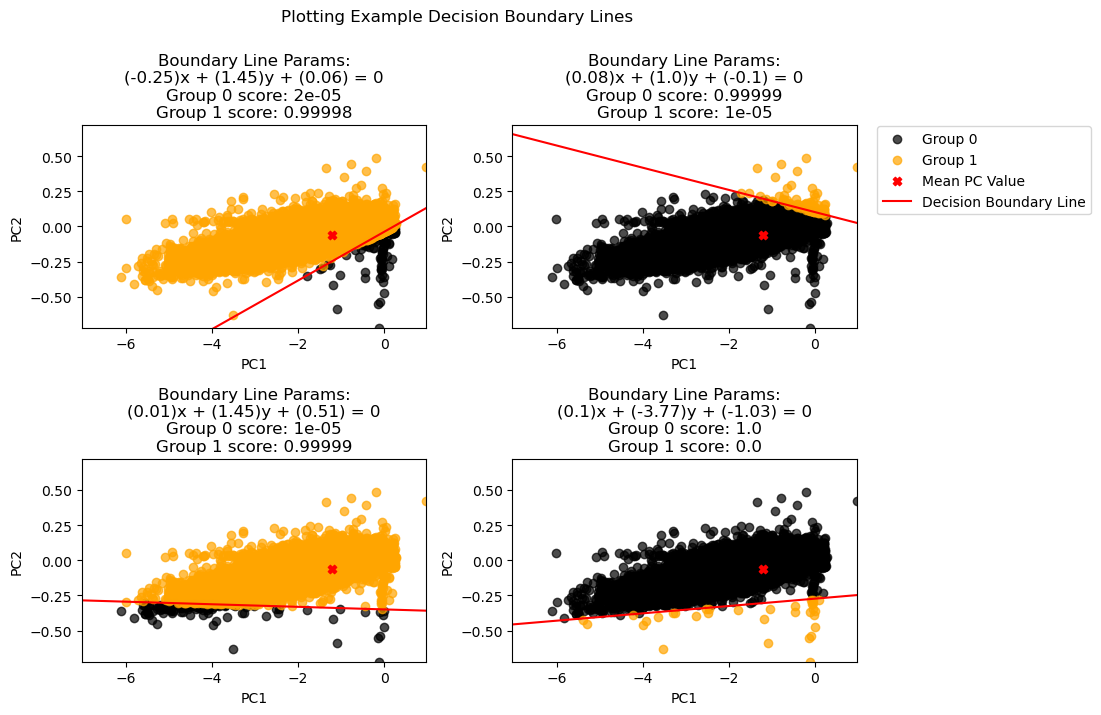

In [22]:
### Plotting results ---> Re-run this cell to generate new plots

# randomLine_parameters(data, min_max_dict, offset_size)

offset_size = 0.05
pd_count = len(pd_df)

fig,axes = plt.subplots(2,2, figsize=(10,7.5))
for i,ax in enumerate(axes.flatten()):
    A, B, C = randomLine_parameters(df_iforest, min_max_dict, offset_size=0.1)
    x = np.linspace(min_max_dict[0][0], min_max_dict[0][1], 5)
    y = (-A/B)*x + -(C/B)
    pd_df["prediction"] = np.sign(A*pd_df["recon_PC1"] + B*pd_df["recon_PC2"] + C)
    
    # Calculate Values
    n_group0 = len(pd_df[pd_df["prediction"]==-1])
    n_group1 = len(pd_df[pd_df["prediction"]==1])
    ax_title = f"Group 0 score: {np.round((n_group0/pd_count),5)}\nGroup 1 score: {np.round((n_group1/pd_count),5)}"

    # Plot original plot
    ax.scatter(pd_df[(pd_df["prediction"]==-1)]["recon_PC1"], 
                 pd_df[(pd_df["prediction"]==-1)]["recon_PC2"], 
                 alpha=0.7, color="k", label="Group 0")
    ax.scatter(pd_df[pd_df["prediction"]==1]["recon_PC1"], 
                pd_df[pd_df["prediction"]==1]["recon_PC2"], 
                alpha=0.7, color="orange", label="Group 1")
    ax.scatter(pc1_mean, pc2_mean, marker="X", c="r", label="Mean PC Value")
    ax.plot(x,y, color="r", label="Decision Boundary Line")
    ax_title
    ax.set_title(f"Boundary Line Params:\n({np.round(A,2)})x + ({np.round(B,2)})y + ({np.round(C,2)}) = 0\n{ax_title}")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_xlim([min_max_dict[0][0], min_max_dict[0][1]])
    ax.set_ylim([min_max_dict[1][0], min_max_dict[1][1]])
    if i==1:
        ax.legend(loc="upper right", bbox_to_anchor=(1.7, 1.03))

    print(f"{n_group0} examples in group 0 --> Score = {np.round((n_group0/pd_count),5)} ({n_group0}/{pd_count})")
    print(f"{n_group1} examples in group 1 --> Score = {np.round((n_group1/pd_count),5)} ({n_group1}/{pd_count})")
    print()


plt.suptitle("Plotting Example Decision Boundary Lines")
plt.subplots_adjust(wspace=0.25, hspace=0.65, top=0.825)

plt.tight_layout
plt.show()

# Analyzing I-Forest Results

In [7]:
### Get aggregate stats on the mean runs
# String variables
mean_str = "_mean_score"
std_str = "_std_score"
runs = ["1t_10s", "1t_30s", "3t_10s", "3t_30s", "5t_10s", "5t_30s", "7t_10s", "7t_30s"]

mean_columns = [run+mean_str for run in runs]
std_columns = [run+std_str for run in runs]
df_columns = ["id", "ss_id", "stamp_date", "recon_PC1", "recon_PC2"]
power_columns = ["power_kW_values", "reconstructions"]
#########################################################################################
agg_mean_stats = list(eval(", ".join([f"F.min(F.col(\'{col}\')), F.max(F.col(\'{col}\')), F.avg(F.col(\'{col}\')), F.std(F.col(\'{col}\'))" for col in mean_columns])))
print(agg_mean_stats)

[Column<'min(1t_10s_mean_score)'>, Column<'max(1t_10s_mean_score)'>, Column<'avg(1t_10s_mean_score)'>, Column<'std(1t_10s_mean_score)'>, Column<'min(1t_30s_mean_score)'>, Column<'max(1t_30s_mean_score)'>, Column<'avg(1t_30s_mean_score)'>, Column<'std(1t_30s_mean_score)'>, Column<'min(3t_10s_mean_score)'>, Column<'max(3t_10s_mean_score)'>, Column<'avg(3t_10s_mean_score)'>, Column<'std(3t_10s_mean_score)'>, Column<'min(3t_30s_mean_score)'>, Column<'max(3t_30s_mean_score)'>, Column<'avg(3t_30s_mean_score)'>, Column<'std(3t_30s_mean_score)'>, Column<'min(5t_10s_mean_score)'>, Column<'max(5t_10s_mean_score)'>, Column<'avg(5t_10s_mean_score)'>, Column<'std(5t_10s_mean_score)'>, Column<'min(5t_30s_mean_score)'>, Column<'max(5t_30s_mean_score)'>, Column<'avg(5t_30s_mean_score)'>, Column<'std(5t_30s_mean_score)'>, Column<'min(7t_10s_mean_score)'>, Column<'max(7t_10s_mean_score)'>, Column<'avg(7t_10s_mean_score)'>, Column<'std(7t_10s_mean_score)'>, Column<'min(7t_30s_mean_score)'>, Column<'max(7

Aggregate Results for mean scores

1 tree, 10 splits
	Min: 0.411162, Max: 0.90174
	Mean: 0.869935822646948, Std: 0.040723078184519895

1 tree, 30 splits
	Min: 0.39937999999999996, Max: 0.8858080000000002
	Mean: 0.8470363996354442, Std: 0.04753806732328452

3 trees, 10 splits
	Min: 0.41167800000000004, Max: 0.921182
	Mean: 0.8910054256911448, Std: 0.030796998965405144

3 trees, 30 splits
	Min: 0.4246960000000001, Max: 0.918726
	Mean: 0.8908368397464591, Std: 0.03437028110565359

5 tree, 10 splits
	Min: 0.42428, Max: 0.9180820000000001
	Mean: 0.8894842891218668, Std: 0.037724094196559206

5 tree, 30 splits
	Min: 0.42951000000000006, Max: 0.9164919999999999
	Mean: 0.888007215979598, Std: 0.03446467767412983

7 trees, 10 splits
	Min: 0.43790399999999996, Max: 0.923508
	Mean: 0.8944797341874124, Std: 0.0298440359874455

7 trees, 30 splits
	Min: 0.440916, Max: 0.924682
	Mean: 0.8962055521886299, Std: 0.035806881665564914


CPU times: user 280 ms, sys: 11.3 ms, total: 292 ms
Wall time: 5.4 s


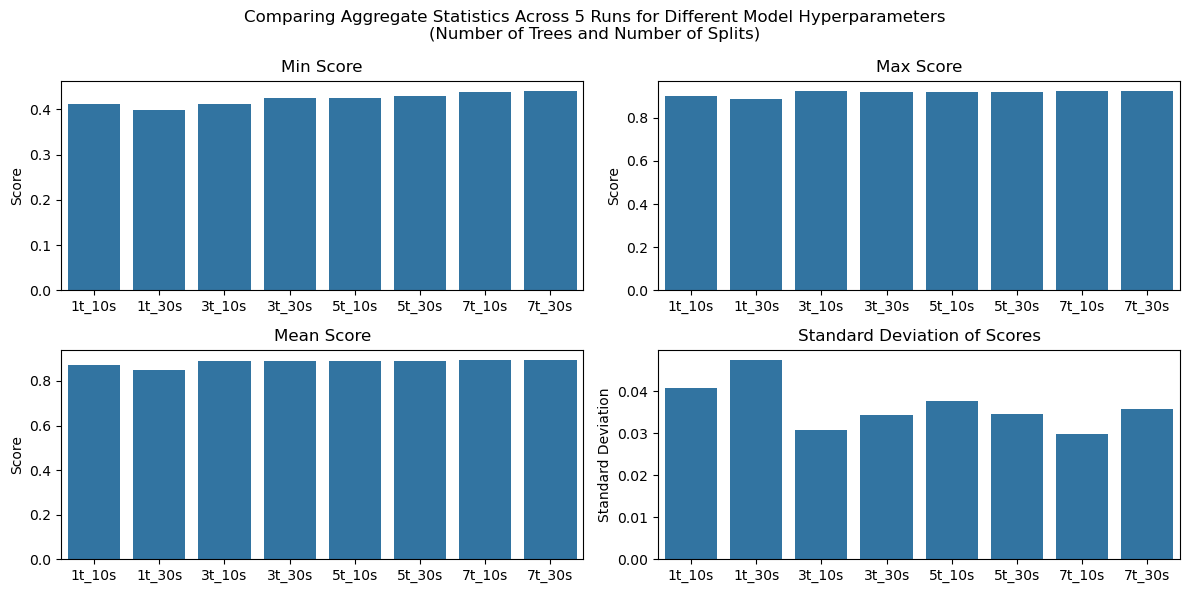

In [16]:
%%time
### Get aggregate stats on the mean runs
# String variables
mean_str = "_mean_score"
std_str = "_std_score"
runs = ["1t_10s", "1t_30s", "3t_10s", "3t_30s", "5t_10s", "5t_30s", "7t_10s", "7t_30s"]

mean_columns = [run+mean_str for run in runs]
std_columns = [run+std_str for run in runs]
df_columns = ["id", "ss_id", "stamp_date", "recon_PC1", "recon_PC2"]
power_columns = ["power_kW_values", "reconstructions"]
#########################################################################################
agg_mean_stats = list(eval(", ".join([f"F.min(F.col(\'{col}\')), F.max(F.col(\'{col}\')), F.avg(F.col(\'{col}\')), F.std(F.col(\'{col}\'))" for col in mean_columns])))
mean_results = df.select(agg_mean_stats).toPandas()
overall_results = df.select(agg_mean_stats).collect()[0]

overall_results_dict = {"min_1t10s":overall_results[0], "max_1t10s":overall_results[1], "mean_1t10s":overall_results[2], "std_1t10s":overall_results[3],
                        "min_1t30s":overall_results[4], "max_1t30s":overall_results[5], "mean_1t30s":overall_results[6], "std_1t30s":overall_results[7],
                        "min_3t10s":overall_results[8], "max_3t10s":overall_results[9], "mean_3t10s":overall_results[10], "std_3t10s":overall_results[11],
                        "min_3t30s":overall_results[12], "max_3t30s":overall_results[13], "mean_3t30s":overall_results[14], "std_3t30s":overall_results[15],
                        "min_5t10s":overall_results[16], "max_5t10s":overall_results[17], "mean_5t10s":overall_results[18], "std_5t10s":overall_results[19],
                        "min_5t30s":overall_results[20], "max_5t30s":overall_results[21], "mean_5t30s":overall_results[22], "std_5t30s":overall_results[23],
                        "min_7t10s":overall_results[24], "max_7t10s":overall_results[25], "mean_7t10s":overall_results[26], "std_7t10s":overall_results[27],
                        "min_7t30s":overall_results[28], "max_7t30s":overall_results[29], "mean_7t30s":overall_results[30], "std_7t30s":overall_results[31]}

print("Aggregate Results for mean scores\n")
print("1 tree, 10 splits")
print(f"\tMin: {overall_results_dict['min_1t10s']}, Max: {overall_results_dict['max_1t10s']}\n\tMean: {overall_results_dict['mean_1t10s']}, Std: {overall_results_dict['std_1t10s']}\n")
print("1 tree, 30 splits")
print(f"\tMin: {overall_results_dict['min_1t30s']}, Max: {overall_results_dict['max_1t30s']}\n\tMean: {overall_results_dict['mean_1t30s']}, Std: {overall_results_dict['std_1t30s']}\n")
print("3 trees, 10 splits")
print(f"\tMin: {overall_results_dict['min_3t10s']}, Max: {overall_results_dict['max_3t10s']}\n\tMean: {overall_results_dict['mean_3t10s']}, Std: {overall_results_dict['std_3t10s']}\n")
print("3 trees, 30 splits")
print(f"\tMin: {overall_results_dict['min_3t30s']}, Max: {overall_results_dict['max_3t30s']}\n\tMean: {overall_results_dict['mean_3t30s']}, Std: {overall_results_dict['std_3t30s']}\n")
print("5 tree, 10 splits")
print(f"\tMin: {overall_results_dict['min_5t10s']}, Max: {overall_results_dict['max_5t10s']}\n\tMean: {overall_results_dict['mean_5t10s']}, Std: {overall_results_dict['std_5t10s']}\n")
print("5 tree, 30 splits")
print(f"\tMin: {overall_results_dict['min_5t30s']}, Max: {overall_results_dict['max_5t30s']}\n\tMean: {overall_results_dict['mean_5t30s']}, Std: {overall_results_dict['std_5t30s']}\n")
print("7 trees, 10 splits")
print(f"\tMin: {overall_results_dict['min_7t10s']}, Max: {overall_results_dict['max_7t10s']}\n\tMean: {overall_results_dict['mean_7t10s']}, Std: {overall_results_dict['std_7t10s']}\n")
print("7 trees, 30 splits")
print(f"\tMin: {overall_results_dict['min_7t30s']}, Max: {overall_results_dict['max_7t30s']}\n\tMean: {overall_results_dict['mean_7t30s']}, Std: {overall_results_dict['std_7t30s']}\n")
print()

#########################################################################################
min_results  = [overall_results_dict[key] for key in ["min_1t10s", "min_1t30s", "min_3t10s", "min_3t30s", "min_5t10s", "min_5t30s", "min_7t10s", "min_7t30s"]]
max_results  = [overall_results_dict[key] for key in ["max_1t10s", "max_1t30s", "max_3t10s", "max_3t30s", "max_5t10s", "max_5t30s", "max_7t10s", "max_7t30s"]]
mean_results = [overall_results_dict[key] for key in ["mean_1t10s", "mean_1t30s", "mean_3t10s", "mean_3t30s", "mean_5t10s", "mean_5t30s", "mean_7t10s", "mean_7t30s"]]
std_results  = [overall_results_dict[key] for key in ["std_1t10s", "std_1t30s", "std_3t10s", "std_3t30s", "std_5t10s", "std_5t30s", "std_7t10s", "std_7t30s"]]
results = [min_results, max_results, mean_results, std_results]
titles = ["Min Score", "Max Score", "Mean Score", "Standard Deviation of Scores"]
ylabels = ["Score", "Score", "Score", "Standard Deviation"]

fig, axes = plt.subplots(2,2, figsize=(12,6))

for result,title,ylabel,ax in zip(results, titles, ylabels, axes.flatten()):
    sns.barplot(x=runs, y=result, ax=ax)
    ax.set(title=title, ylabel=ylabel)

plt.suptitle("Comparing Aggregate Statistics Across 5 Runs for Different Model Hyperparameters\n(Number of Trees and Number of Splits)")
plt.tight_layout()

The model with the least variance in output scores for each individual point is 7 trees with 10 splits



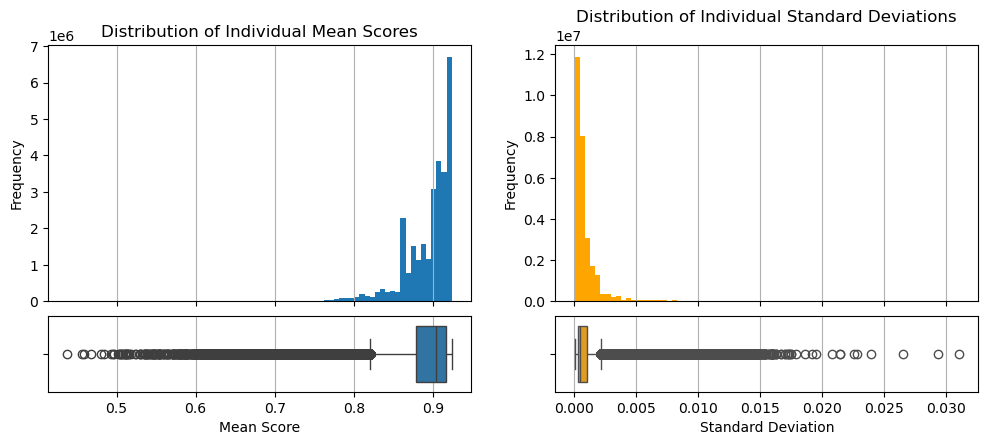

CPU times: user 2min 13s, sys: 9.76 s, total: 2min 23s
Wall time: 2min 28s


In [25]:
%%time
### Compare variances, then analyze the one with the least variance
print("The model with the least variance in output scores for each individual point is 7 trees with 10 splits")
print()

pd_df = df.select(F.col("7t_10s_mean_score").alias("mean_score"), F.col("7t_10s_std_score").alias("std_score")).toPandas()

fig = plt.figure(figsize=(12,4.5))
grid = plt.GridSpec(4,2, wspace=0.2, hspace=0.2)

mean_hist = fig.add_subplot(grid[:3,0])
mean_hist.hist(pd_df["mean_score"], bins=75)
mean_hist.set(title="Distribution of Individual Mean Scores", ylabel="Frequency")
mean_hist.grid(axis="x")
mean_hist.xaxis.set_tick_params(labelbottom=False)

std_hist = fig.add_subplot(grid[:3,1])
std_hist.hist(pd_df["std_score"], bins=75, color="orange")
std_hist.set(title="Distribution of Individual Standard Deviations", ylabel="Frequency")
std_hist.grid(axis="x")
std_hist.xaxis.set_tick_params(labelbottom=False)

mean_box = fig.add_subplot(grid[3,0])
sns.boxplot(pd_df["mean_score"], orient="h", widths=0.75, showfliers=True, ax=mean_box)
mean_box.set(xlabel="Mean Score")
mean_box.grid(axis="x")

std_box = fig.add_subplot(grid[3,1])
sns.boxplot(pd_df["std_score"], orient="h", widths=0.75, showfliers=True, ax=std_box, color="orange")
std_box.set(xlabel="Standard Deviation")
std_box.grid(axis="x")

plt.show()

In [5]:
###
print("As this anomaly detection method is an unsupervised learning task, there is no exact method to define an outlier.")
print("We will define all points whose scores fall outside of Q1 - 1.5 * IQR as an outlier")

### Calculating the mean PC1 and PC2 for plots
mean_pc1, mean_pc2 = df.select(F.avg("recon_PC1"), F.avg("recon_PC2")).collect()[0]

As this anomaly detection method is an unsupervised learning task, there is no exact method to define an outlier.
We will define all points whose scores fall outside of Q1 - 1.5 * IQR as an outlier


In [248]:
%%time
### Filter for all points that are an outlier and export the grouping to Pandas for further analysis

# Find the Q1 - 1.5*IQR cutoff
score_column_quantiles = df.approxQuantile(col="7t_10s_mean_score", probabilities=[0.25, 0.75], relativeError = 0.0001)
print("Quantiles:", score_column_quantiles)
Q1 = score_column_quantiles[0]
Q3 = score_column_quantiles[1]

# Calculate the respective IQR values and then the lower whiskers for outlier scores
score_cutoff = Q1 - 1.5*(Q3-Q1)
print("Cutoff Value:", score_cutoff)

# Add a filter to df to locate all points below these ranges --> Save a version as csv
df_outliers = df.where(F.col("7t_10s_mean_score") < score_cutoff)

df_outliers.select("id", "ss_id", "stamp_date", F.col("7t_10s_mean_score").alias("score")).toPandas() \
           .to_csv("outliers/4_iforest_outliers.csv", header=True)

pd_df = df_outliers.select("id", "recon_PC1", "recon_PC2", F.col("7t_10s_mean_score").alias("score")).toPandas()

pd_df[["recon_PC1", "recon_PC2", "score"]].describe()

Quantiles: [0.877984, 0.916732]
Cutoff Value: 0.819862
CPU times: user 10.7 s, sys: 306 ms, total: 11.1 s
Wall time: 45.3 s


,recon_PC1,recon_PC2,score
count,941135.000000,941135.000000,941135.000000
mean,-3.197216,-0.166121,0.793543
std,0.245739,0.033047,0.023383
min,-7.031215,-0.722353,0.437904
25%,-3.326609,-0.186529,0.784206
50%,-3.142971,-0.164472,0.799884
75%,-3.017415,-0.145414,0.810978
max,0.981797,0.719465,0.819860


In [251]:
### Get a sample of the normal range points for plotting purposes
df_normal = df.where(F.col("7t_10s_mean_score") > score_cutoff) \
              .select("id", "recon_PC1", "recon_PC2", F.col("7t_10s_mean_score").alias("score")).toPandas()
df_normal

,id,recon_PC1,recon_PC2,score
0,964,0.000000,0.000000,0.865104
1,2214,-0.532347,-0.024436,0.907168
2,2453,-2.303802,-0.154841,0.865756
3,4590,-1.829184,-0.103105,0.902416
4,4823,-0.099946,-0.010452,0.870172
...,...,...,...,...
27146829,858994108833,-0.758369,-0.039299,0.919206
27146830,858994109219,-0.122239,-0.005204,0.870172
27146831,858994109394,-0.723296,-0.035037,0.918438
27146832,858994109486,-1.047417,-0.051345,0.923414


In [252]:
%%time
### Plot the points 
pd_df2 = pd_df.copy()
df_normal2 = df_normal.copy()

# Add column to differentiate outliers from normal
pd_df2["outlier"] = 1
df_normal2["outlier"] = 0

# Add column to discretize the scores
pd_df2["score_binned"] = np.round(np.round(pd_df2["score"], 1)/2, 2)
df_normal2["score_binned"] = np.round(np.round(df_normal2["score"], 1)/2, 2)

# Add column to discretize into normal vs discretized outleirs
pd_df2["score_binned2"] = np.round(np.round(pd_df2["score"], 1)/2, 2)
df_normal2["score_binned2"] = 1

df_normal2

CPU times: user 263 ms, sys: 196 ms, total: 459 ms
Wall time: 461 ms


,id,recon_PC1,recon_PC2,score,outlier,score_binned,score_binned2
0,964,0.000000,0.000000,0.865104,0,0.45,1
1,2214,-0.532347,-0.024436,0.907168,0,0.45,1
2,2453,-2.303802,-0.154841,0.865756,0,0.45,1
3,4590,-1.829184,-0.103105,0.902416,0,0.45,1
4,4823,-0.099946,-0.010452,0.870172,0,0.45,1
...,...,...,...,...,...,...,...
27146829,858994108833,-0.758369,-0.039299,0.919206,0,0.45,1
27146830,858994109219,-0.122239,-0.005204,0.870172,0,0.45,1
27146831,858994109394,-0.723296,-0.035037,0.918438,0,0.45,1
27146832,858994109486,-1.047417,-0.051345,0.923414,0,0.45,1


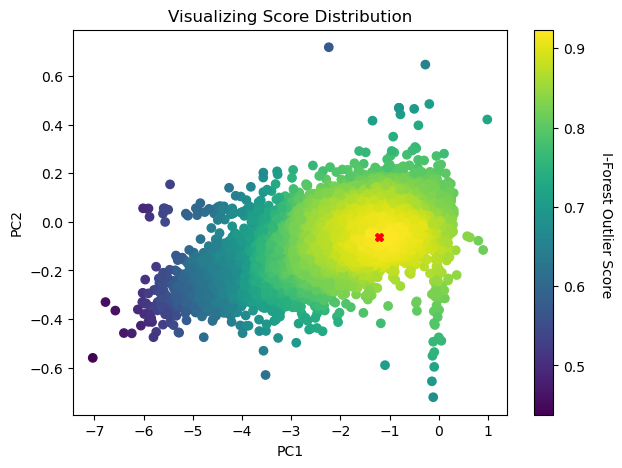

In [258]:
### Plot with a regular colormap

fig,ax = plt.subplots(1,1, figsize=(7,5))
combined = pd.concat([pd_df2, df_normal2], axis=0)#.sample(n=100000)
main_plt = ax.scatter(combined["recon_PC1"], combined["recon_PC2"], c=combined["score"], cmap="viridis")
ax.plot(mean_pc1, mean_pc2, "rX")
ax.set(title="Visualizing Score Distribution", xlabel="PC1", ylabel="PC2") 
plt.text(3.25, -0.3, "I-Forest Outlier Score", fontsize=10, rotation=270)
plt.colorbar(main_plt)
plt.show()

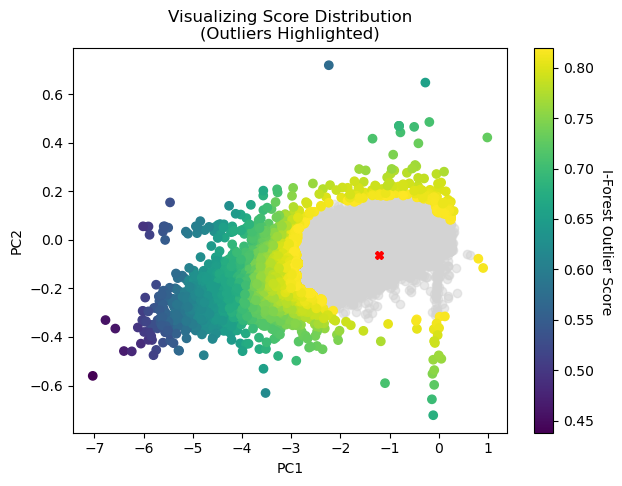

In [260]:
### Plot with discretized scores

fig,ax = plt.subplots(1,1, figsize=(7,5))
normal_plt = ax.scatter(df_normal2["recon_PC1"], df_normal2["recon_PC2"], color="lightgrey", alpha=0.5)
main_plt = ax.scatter(pd_df2["recon_PC1"], pd_df2["recon_PC2"], c=pd_df2["score"], cmap="viridis")
ax.plot(mean_pc1, mean_pc2, "rX")
ax.set(title="Visualizing Score Distribution\n(Outliers Highlighted)", xlabel="PC1", ylabel="PC2") 
plt.text(3.25, -0.3, "I-Forest Outlier Score", fontsize=10, rotation=270)
plt.colorbar(main_plt)
plt.show()

In [42]:
%%time
### Visualize average curves within each anomaly group (rounded to nearest .1) vs non-outliers
assemble_power = VectorAssembler(inputCols = [f"power_kW_values[{i}]" for i in range(0,48)], outputCol="power_kW_values2")
assemble_recon = VectorAssembler(inputCols = [f"reconstructions[{i}]" for i in range(0,48)], outputCol="reconstructions2")
# summarizer = Summarizer.metrics("mean")

df_normal = df.select("id", "power_kW_values", "reconstructions", F.col("7t_10s_mean_score").alias("score")) \
              .where(F.col("score") >= score_cutoff) \
              .withColumn("score", F.round(F.round(F.col("score") * 2, 1)/2, 2))
df_outlier = df.select("id", "power_kW_values", "reconstructions", F.col("7t_10s_mean_score").alias("score")) \
               .where(F.col("score") < score_cutoff) \
               .withColumn("score", F.round(F.round(F.col("score") * 2, 1)/2, 2))

### Calculate normal curve mean power/recon
df_normal = assemble_power.transform(df_normal.select("*", *(F.col("power_kW_values").getItem(i) for i in range(0,48))))
df_normal = assemble_recon.transform(df_normal.select("*", *(F.col("reconstructions").getItem(i) for i in range(0,48))))
df_normal = df_normal.select("id", "power_kW_values2", "reconstructions2", "score")
df_normal.show(5)

normal_mean_powers = df_normal.groupBy("score").agg(Summarizer.mean(F.col("power_kW_values2")).alias("mean_power"))
normal_mean_recons = df_normal.groupBy("score").agg(Summarizer.mean(F.col("reconstructions2")).alias("mean_recon"))

### Calculate outlier curve mean power/recon (grouped by outlier score)
df_outlier = assemble_power.transform(df_outlier.select("*", *(F.col("power_kW_values").getItem(i) for i in range(0,48))))
df_outlier = assemble_recon.transform(df_outlier.select("*", *(F.col("reconstructions").getItem(i) for i in range(0,48))))
df_outlier = df_outlier.select("id", "power_kW_values2", "reconstructions2", "score")
df_outlier.show(5)

outlier_mean_powers = df_outlier.groupBy("score").agg(Summarizer.mean(F.col("power_kW_values2")).alias("mean_power"))
outlier_mean_recons = df_outlier.groupBy("score").agg(Summarizer.mean(F.col("reconstructions2")).alias("mean_recon"))

+----+--------------------+--------------------+-----+
|  id|    power_kW_values2|    reconstructions2|score|
+----+--------------------+--------------------+-----+
| 964|          (48,[],[])|          (48,[],[])| 0.85|
|2214|(48,[16,17,18,19,...|[-7.7612569255096...|  0.9|
|2453|(48,[15,16,17,18,...|[-0.0112027525318...| 0.85|
|4590|[0.0,0.0,0.0,0.0,...|[0.00988028907622...|  0.9|
|4823|(48,[18,19,20,21,...|[0.00274011271349...| 0.85|
+----+--------------------+--------------------+-----+
only showing top 5 rows

+-----+--------------------+--------------------+-----+
|   id|    power_kW_values2|    reconstructions2|score|
+-----+--------------------+--------------------+-----+
| 8075|(48,[12,13,14,15,...|[-0.0012342951432...| 0.75|
|15371|(48,[9,10,11,12,1...|[-0.0080371676819...|  0.8|
|56309|(48,[9,10,11,12,1...|[0.00188118863935...|  0.8|
|71429|(48,[11,12,13,14,...|[-6.3836599068738...|  0.8|
|82876|(48,[11,12,13,14,...|[-0.0021974213740...|  0.8|
+-----+--------------------+----

In [43]:
normal_mean_power_df = normal_mean_powers.toPandas()
normal_mean_recon_df = normal_mean_recons.toPandas()
outlier_mean_power_df = outlier_mean_powers.toPandas()
outlier_mean_recon_df = outlier_mean_recons.toPandas()

Number of normal groupings: 8


Text(0.5, 0.98, 'Average Reconstruction Curves of Normal Points\n(Grouped by Score Rounded to Nearest 0.5)')

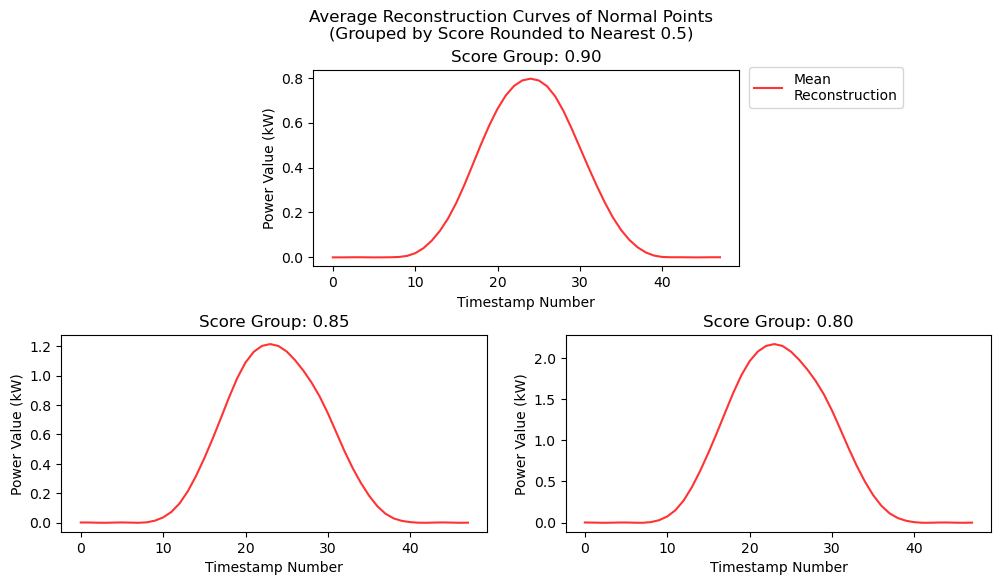

In [75]:
### Setting up the x range
x = [i for i in np.arange(0,48)]

### Setting up the gridspec subplots
fig = plt.figure(figsize=(12,6))
grid = plt.GridSpec(2,4, wspace=0.45, hspace=0.35)

plot1 = fig.add_subplot(grid[0,1:3])
plot2 = fig.add_subplot(grid[1,0:2])
plot3 = fig.add_subplot(grid[1,2:])
axes = [plot1, plot2, plot3]

### Combining normal dfs
normal_df = pd.merge(normal_mean_power_df, normal_mean_recon_df, how="inner", on="score") \
               .sort_values("score", ascending=False) \
               .reset_index(drop=True)

### Plotting normal curves
print("Number of normal groupings:", len(outlier_df))

for i,ax in enumerate(axes):
    power = normal_df["mean_power"][i].values
    recon = normal_df["mean_recon"][i].values
    ax.plot(x, recon, "r", alpha=0.8, label="Mean\nReconstruction")
    ax.set(xlabel="Timestamp Number", ylabel="Power Value (kW)", title=f"Score Group: {normal_df['score'][i]:.2f}")
    if i==0:
        ax.legend(loc="upper right", bbox_to_anchor=([1.4, 1.05]))

plt.suptitle("Average Reconstruction Curves of Normal Points\n(Grouped by Score Rounded to Nearest 0.5)")

Number of outlier groupings: 8


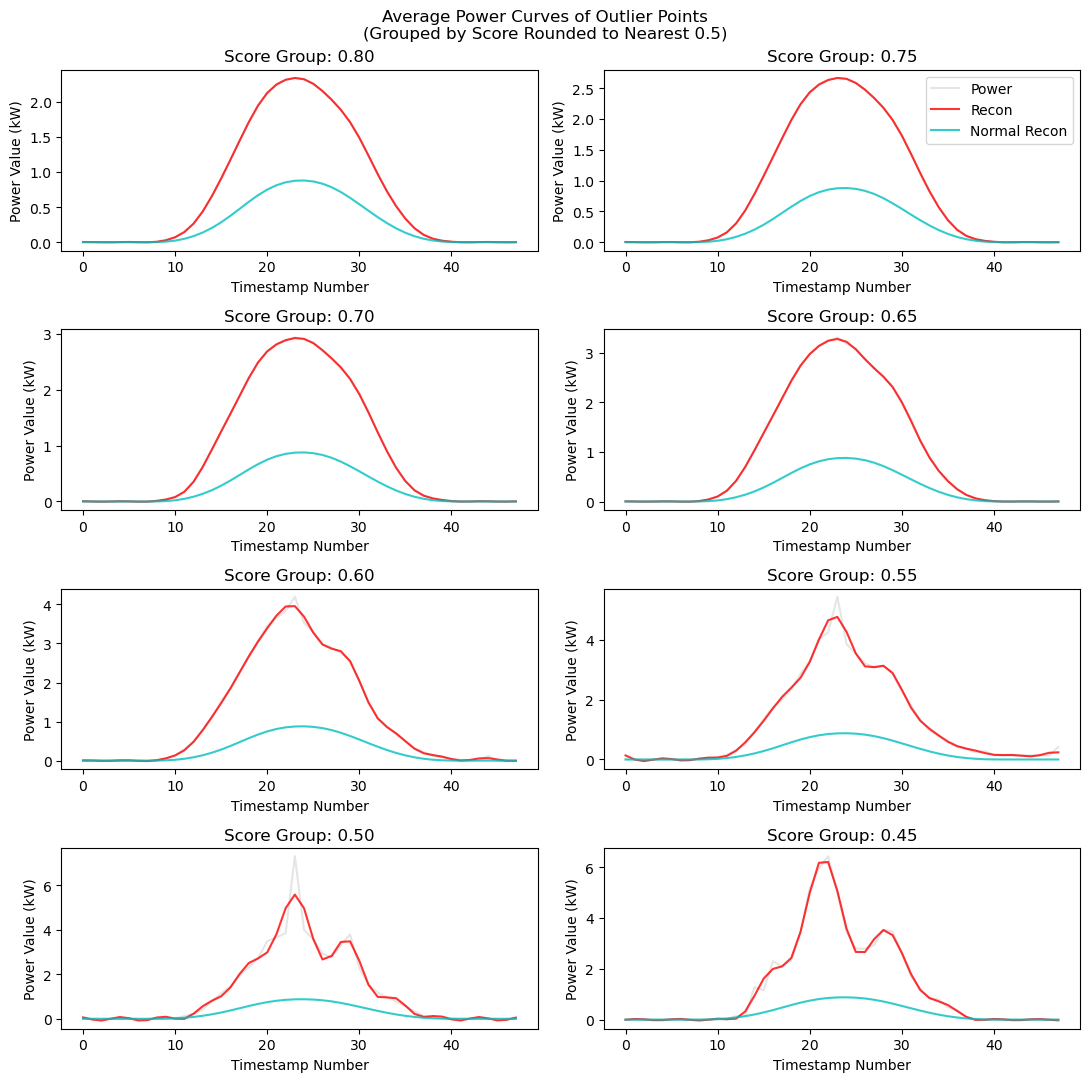

In [53]:
### Combining outlier dfs
outlier_df = pd.merge(outlier_mean_power_df, outlier_mean_recon_df, how="inner", on="score") \
               .sort_values("score", ascending=False) \
               .reset_index(drop=True)

### Plotting outlier curves
print("Number of outlier groupings:", len(outlier_df))

fig,axes = plt.subplots(4,2, figsize=(11,11))
for i,ax in enumerate(axes.flatten()):
    power = outlier_df["mean_power"][i].values
    recon = outlier_df["mean_recon"][i].values

    ax1 = ax.plot(x, power, "k", alpha=0.1, label="Power")
    ax2 = ax.plot(x, recon, "r", alpha=0.8, label="Recon")
    ax3 = ax.plot(x, normal_recon, "c", alpha=0.8, label="Normal Recon")
    ax.set(xlabel="Timestamp Number", ylabel="Power Value (kW)", title=f"Score Group: {outlier_df['score'][i]:.2f}")
    if i==1:
        ax.legend()
plt.suptitle("Average Power Curves of Outlier Points\n(Grouped by Score Rounded to Nearest 0.5)")
plt.tight_layout()


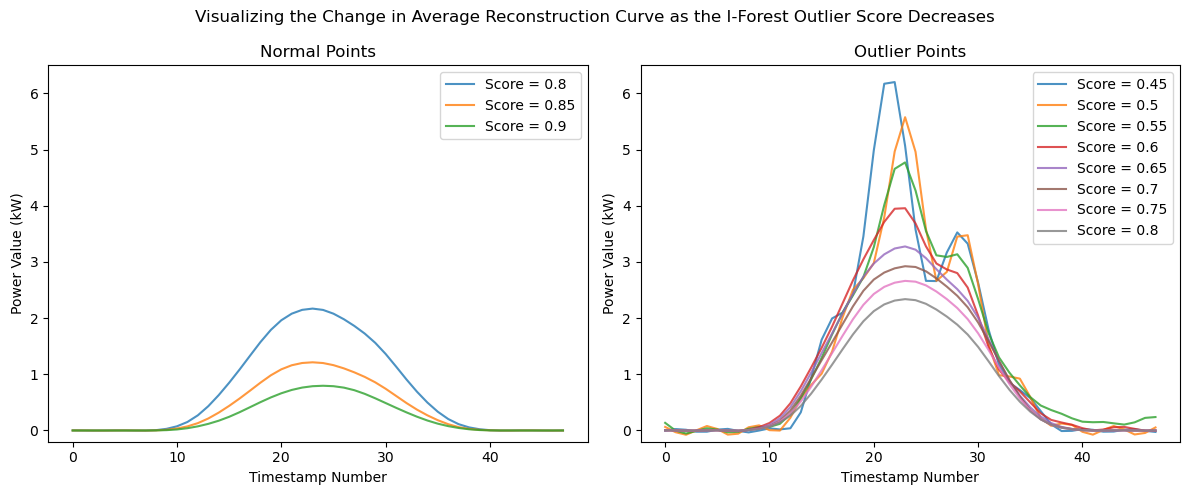

In [149]:
### Plotting the normal power curves
### Combining normal dfs
normal_df = pd.merge(normal_mean_power_df, normal_mean_recon_df, how="inner", on="score") \
               .sort_values("score", ascending=True) \
               .reset_index(drop=True)
### Combining outlier dfs
outlier_df = pd.merge(outlier_mean_power_df, outlier_mean_recon_df, how="inner", on="score") \
               .sort_values("score", ascending=True) \
               .reset_index(drop=True)



fig,ax = plt.subplots(1,2, figsize=(12,5))
for i in range(0,len(normal_df)):
    recon = normal_df["mean_recon"][i].values
    score = normal_df["score"][i]

    ax[0].plot(x, recon, alpha=0.8, label=f"Score = {score}")
    ax[0].set(xlabel="Timestamp Number", ylabel="Power Value (kW)", title="Normal Points", ylim=[-.2,6.5])
    ax[0].legend()

for i in range(0, len(outlier_df)):
    recon = outlier_df["mean_recon"][i].values
    score = outlier_df["score"][i]

    ax[1].plot(x, recon, alpha=0.8, label=f"Score = {score}")
    ax[1].set(xlabel="Timestamp Number", ylabel="Power Value (kW)", title="Outlier Points", ylim=[-.2,6.5])
    ax[1].legend()
    
plt.suptitle("Visualizing the Change in Average Reconstruction Curve as the I-Forest Outlier Score Decreases")
plt.tight_layout()

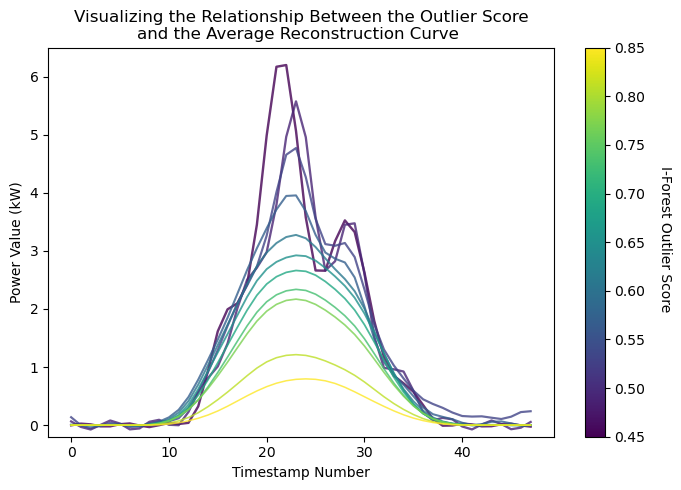

In [255]:
### Plotting the normal power curves
### Combining normal dfs
normal_df = pd.merge(normal_mean_power_df, normal_mean_recon_df, how="inner", on="score") 
normal_df["type"] = "Normal"
### Combining outlier dfs
outlier_df = pd.merge(outlier_mean_power_df, outlier_mean_recon_df, how="inner", on="score") 
outlier_df["type"] = "Outlier"
### Combining both dfs
both_df = pd.concat([normal_df, outlier_df], axis=0) \
            .sort_values(["score", "type"], ascending=[True, False]) \
            .reset_index(drop=True)
### Getting the colormap
colors = plt.colormaps["viridis"](np.linspace(0,1,len(both_df)))
### Prep the figure/axis
fig,ax = plt.subplots(1,1, figsize=(7,5))
### Prep the colorbar by setting up a fake plot, then clearing the axis
color_i = np.arange(both_df["score"].min(),both_df["score"].max(),0.05)
color_ax = ax.scatter(color_i, color_i, c=color_i, cmap="viridis")
ax.set_ylabel("I-Forest Outlier Score")
ax.yaxis.set_label_position("right")
fig.colorbar(color_ax, ticks=color_i)
plt.cla()

for i in range(0,len(both_df)):
    recon = both_df["mean_recon"][i].values
    score = both_df["score"][i]
    score_type = both_df["type"][i]

    ax.plot(x, recon, alpha=0.8, label=f"{score_type}_Score = {score}", color=colors[i], linewidth=np.exp(1-score)*1)
    ax.set(xlabel="Timestamp Number", ylabel="Power Value (kW)", 
              title="Visualizing the Relationship Between the Outlier Score\nand the Average Reconstruction Curve ", 
              ylim=[-.2,6.5])

plt.text(60, 2, "I-Forest Outlier Score", fontsize=10, rotation=270)
plt.tight_layout()